In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from skimage.color import gray2rgb

In [2]:
# get dataset and split it into two datasets (training, testing)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# preprocessing the data
def preprocess_data(X, y):
    # normalization
    X = X.astype("float32") / 255
    X = np.array([gray2rgb(img) for img in X])
    # one-hot encoding
    y = np_utils.to_categorical(y)
    return X, y

X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)

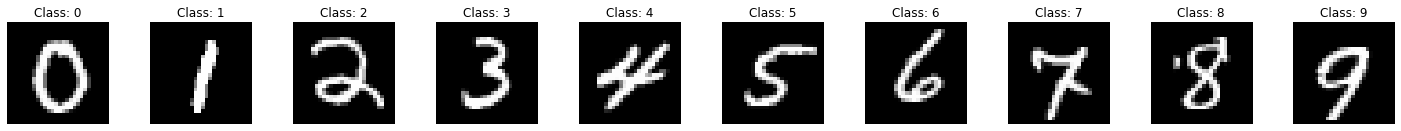

In [4]:
np.random.seed(100)

examples = []
for i in range(10):
    indexes = np.where(np.argmax(y_test, axis=1) == i)
    all_indexes = np.hstack(indexes)
    examples.append(np.random.choice(all_indexes))

# show examples
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[examples][i])
    ax.title.set_text(f'Class: {np.argmax(y_test[examples][i])}')
    ax.axis('off')

In [5]:
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 3)
60000 train samples
10000 test samples


In [6]:
import keras
import tensorflow as tf

In [7]:
model = keras.Sequential(
    [
        keras.Input(shape=np.shape(X_train)[1:]),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(1, 1)),        
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dropout (Dropout)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 10)                216330    
                                                                 
Total params: 217,226
Trainable params: 217,226
Non-trainable params: 0
__________________________________________________

In [9]:
model.fit(X_train, y_train, epochs=5, batch_size=10, validation_split=0.1)

Epoch 1/5
5400/5400 [==============================] - 35s 6ms/step - loss: 0.1755 - accuracy: 0.9464 - val_loss: 0.0719 - val_accuracy: 0.9807
Epoch 2/5
5400/5400 [==============================] - 31s 6ms/step - loss: 0.0902 - accuracy: 0.9726 - val_loss: 0.0626 - val_accuracy: 0.9822
Epoch 3/5
5400/5400 [==============================] - 31s 6ms/step - loss: 0.0695 - accuracy: 0.9780 - val_loss: 0.0593 - val_accuracy: 0.9840
Epoch 4/5
5400/5400 [==============================] - 31s 6ms/step - loss: 0.0550 - accuracy: 0.9828 - val_loss: 0.0604 - val_accuracy: 0.9842
Epoch 5/5
5400/5400 [==============================] - 31s 6ms/step - loss: 0.0479 - accuracy: 0.9839 - val_loss: 0.0592 - val_accuracy: 0.9850


In [10]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Test loss:", '\t', loss)
print("Test accuracy:", '\t', accuracy)

Test loss: 	 0.06463426351547241
Test accuracy: 	 0.980400025844574


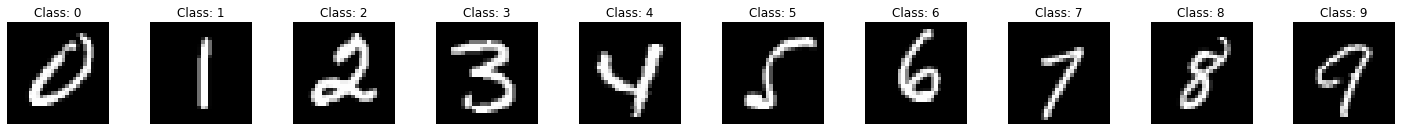

In [11]:
# images to classify and explain
np.random.seed(10)

to_explain = []
for i in range(10):
    indexes = np.where(np.argmax(y_test, axis=1) == i)
    all_indexes = np.hstack(indexes)
    to_explain.append(np.random.choice(all_indexes))

fig, axes = plt.subplots(1, 10, figsize=(20, 3))
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[to_explain][i])
    ax.title.set_text(f'Class: {np.argmax(y_test[to_explain][i])}')
    ax.axis('off')

### 1. LIME

In [12]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [13]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
explainer = lime_image.LimeImageExplainer(verbose=False)

In [ ]:
explanations = [
    explainer.explain_instance(
        X_test[to_explain][i], 
        classifier_fn=model.predict, 
        top_labels=10, 
        hide_color=0, 
        num_samples=10000,
        segmentation_fn=segmenter
    ) for i in range(10)
]

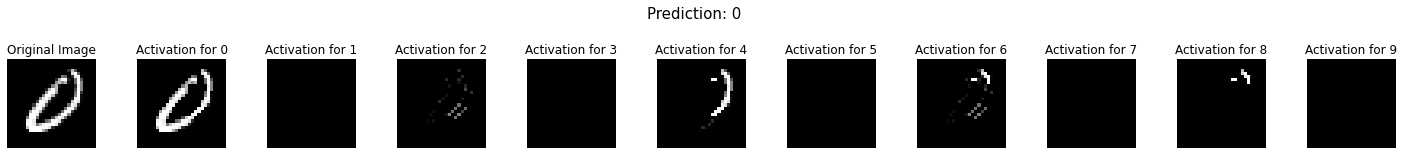

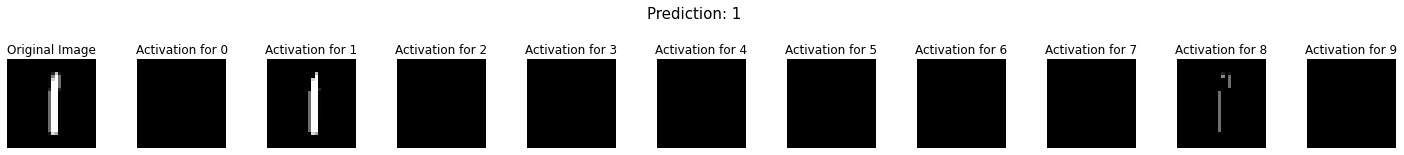

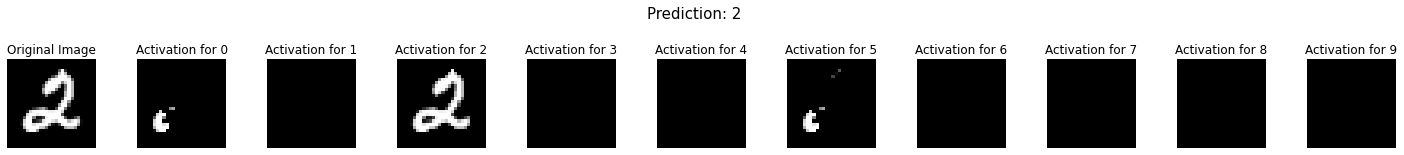

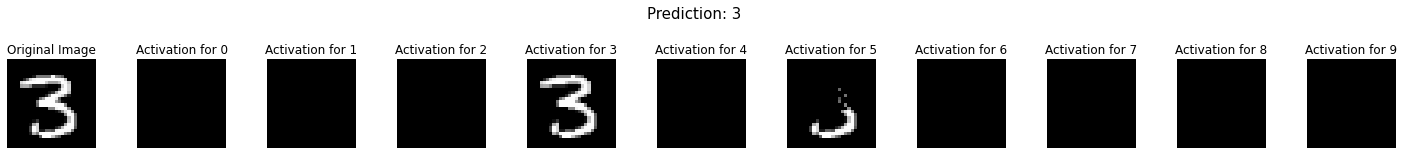

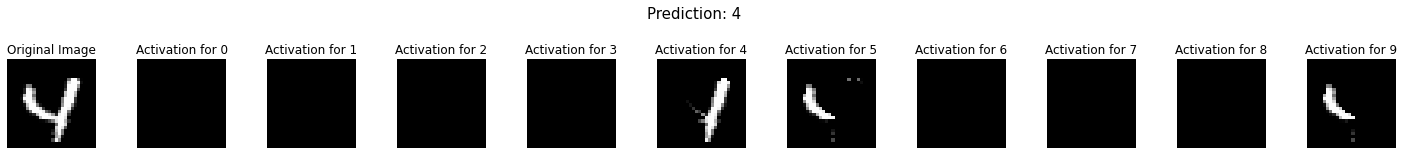

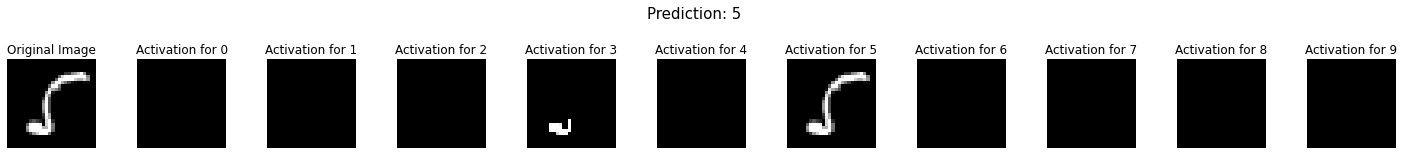

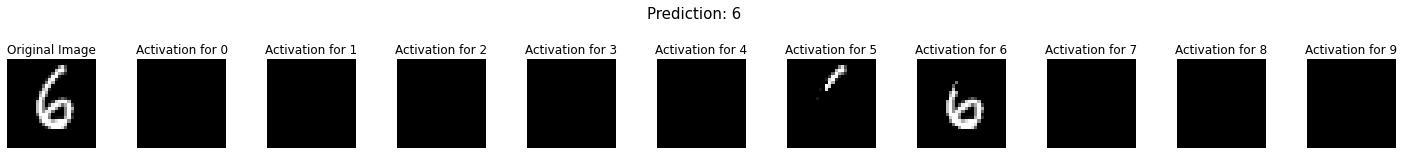

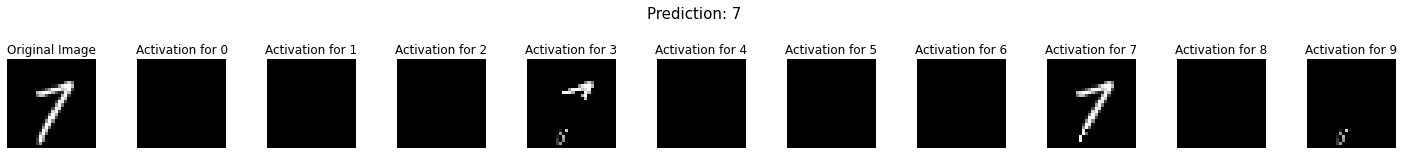

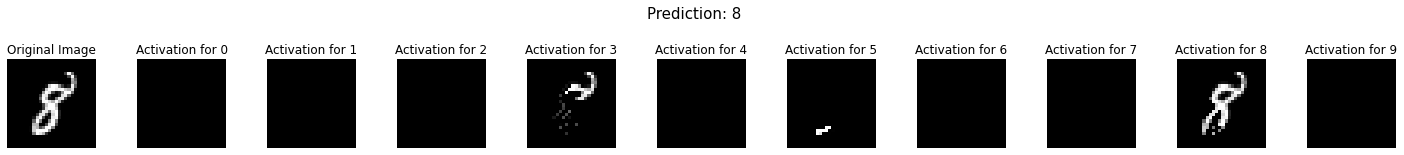

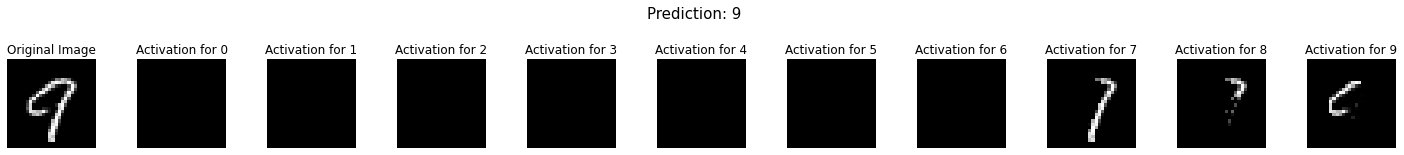

In [15]:
for i_exp, explanation in enumerate(explanations):
    fig, axes = plt.subplots(1, 11, figsize=(20, 3))
    fig.tight_layout()
    for i, c_ax in enumerate(axes.flatten()):
        if i == 0:
            c_ax.imshow(X_test[to_explain][i_exp])
            c_ax.set_title(f'Original Image')
            c_ax.axis('off')
        else:
            temp, mask = explanation.get_image_and_mask(i - 1, positive_only=True, hide_rest=True, min_weight=0.02)
            c_ax.imshow(temp)
            c_ax.set_title(f'Activation for {i - 1}')
            c_ax.axis('off')
    fig.suptitle(f'Prediction: {explanation.top_labels[0]}', fontsize=15)

### 2. SHAP

In [16]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

In [17]:
# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(X_test[to_explain])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Prediction: 0


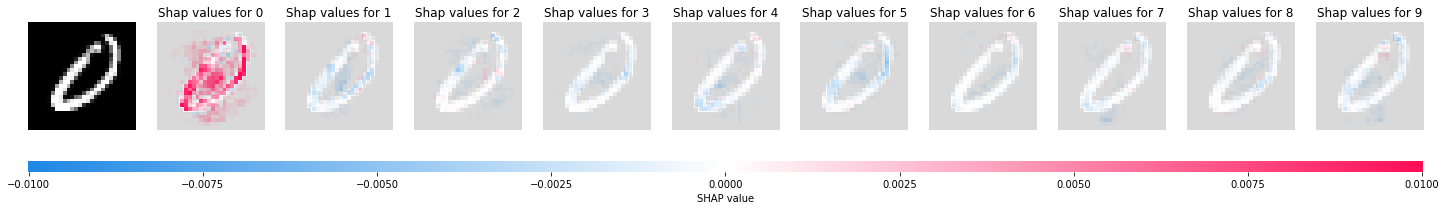

Prediction: 1


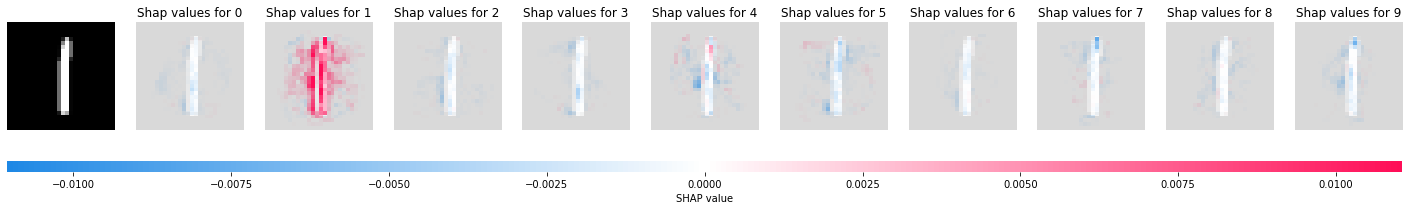

Prediction: 2


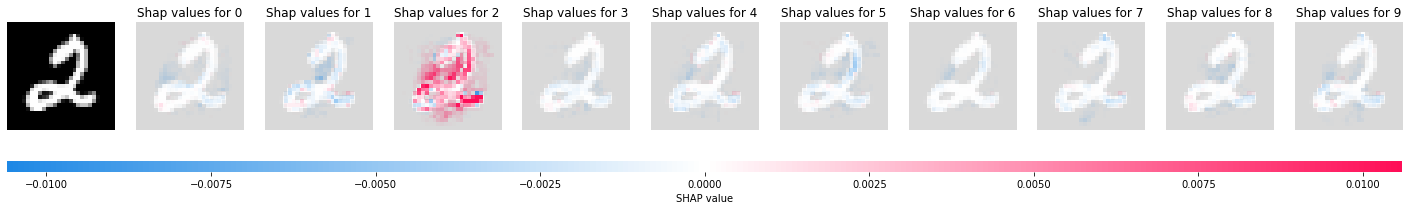

Prediction: 3


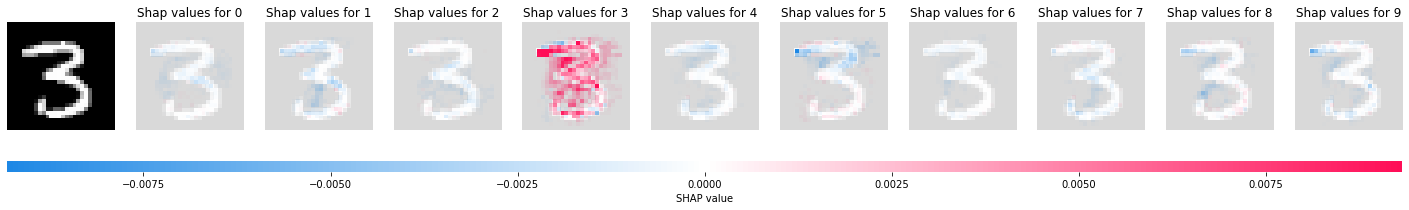

Prediction: 4


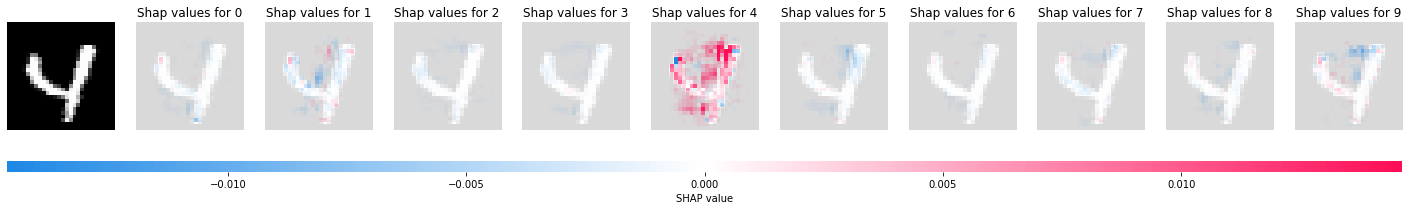

Prediction: 5


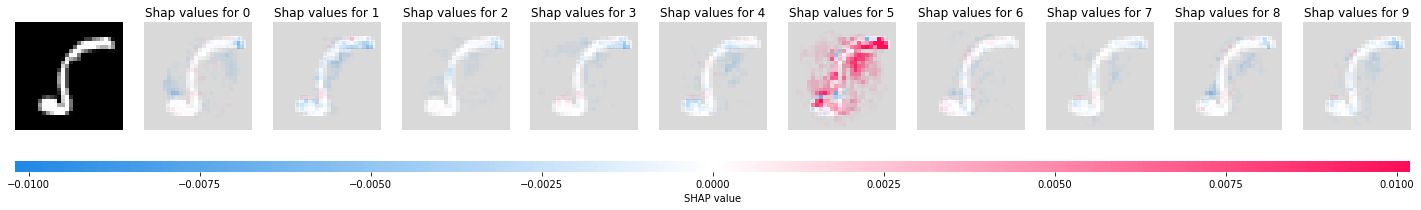

Prediction: 6


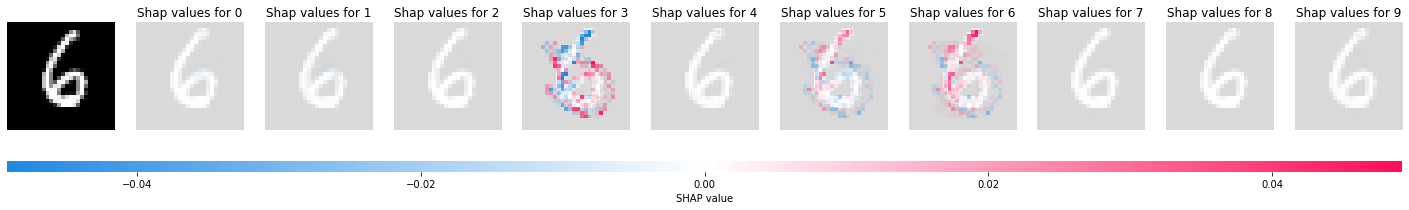

Prediction: 7


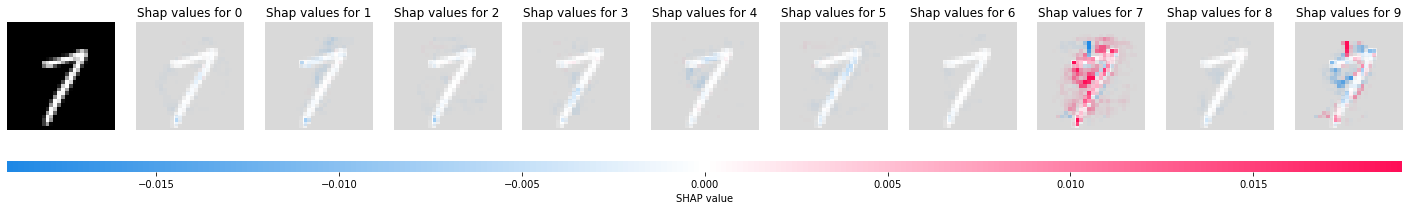

Prediction: 8


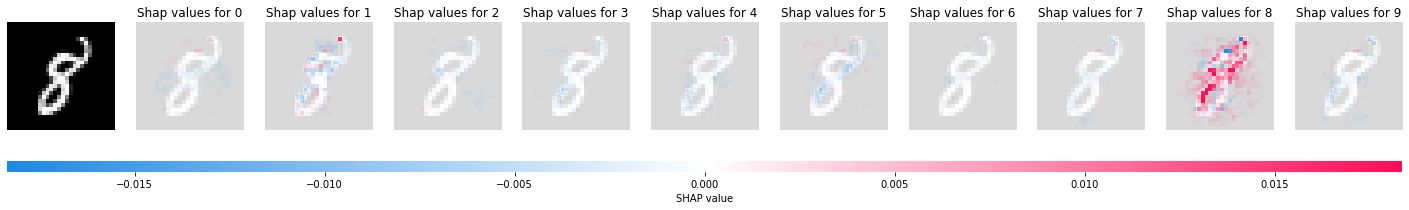

Prediction: 9


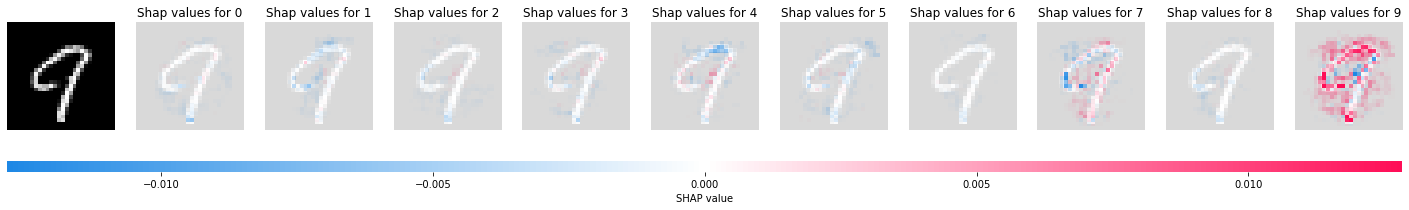

In [43]:
for i in range(10):
    shap.image_plot(
        list(np.array(shap_values)[:, i:i+1, :, :, :]), 
        X_test[to_explain[i:i+1]], 
        width=25, show=False, 
        labels=[f'Shap values for {sh_v}' for sh_v in range(10)]
    )
    print('Prediction:', np.argmax(model.predict(X_test[to_explain[i:i+1]], verbose=False)[0]))
    plt.show()